# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [36]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

0.152812705583
loss: 2.187554
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Ten classes, the loss function is log ( e^fyi / sum( e^fj)) 

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.695228 analytic: 1.573958, relative error: 3.709503e-02
numerical: -1.620844 analytic: -1.446770, relative error: 5.674563e-02
numerical: -1.313512 analytic: -1.074078, relative error: 1.002828e-01
numerical: -3.669187 analytic: -3.280614, relative error: 5.591138e-02
numerical: -1.213812 analytic: -1.132889, relative error: 3.448374e-02
numerical: -0.647513 analytic: -0.566325, relative error: 6.688473e-02
numerical: -0.315570 analytic: -0.294463, relative error: 3.460041e-02
numerical: -2.284384 analytic: -2.067076, relative error: 4.993913e-02
numerical: -4.648331 analytic: -4.200937, relative error: 5.055719e-02
numerical: 2.912480 analytic: 2.677898, relative error: 4.196170e-02
numerical: 0.594560 analytic: 0.656716, relative error: 4.967391e-02
numerical: -0.587802 analytic: -0.812958, relative error: 1.607382e-01
numerical: 3.415204 analytic: 3.248493, relative error: 2.501786e-02
numerical: -0.164199 analytic: -0.127115, relative error: 1.272982e-01
numerical: 5.9

In [65]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference
#print grad_naive
#print grad_vectorized

0.152812705583
naive loss: 2.187554e+00 computed in 1.150900s
[ 6.44792942  6.5864609   7.11456045  4.8520786   6.15189473  8.02729929
  6.51913519  6.80803332  6.73556564  8.65702641  7.64324903  6.40776209
  4.72246593  7.35362837  5.42322581  6.98502303  7.4714229   5.34812219
  6.68524369  6.97615577  6.82720013  7.78697415  5.87560242  7.47562311
  5.94301876  5.70983823  7.22849204  4.87967773  5.51289508  5.60588832
  4.12401359  7.66427971  7.47798225  6.99201279  7.79227051  6.17435668
  7.08384392  7.22645471  5.12909095  7.28028864  5.03287371  4.66562013
  5.49496876  5.69125068  5.90488699  6.75799243  6.34801589  7.01346455
  5.53508734  8.24792343  5.58938319  6.63026257  7.1478234   7.13222
  5.08966903  4.7679209   6.41278588  3.443676    6.90707534  5.82457148
  4.47539862  7.33544623  7.10968007  6.55271613  7.49656134  7.23127901
  6.3285788   6.07727246  4.58811752  7.82316006  7.56875572  5.54112688
  5.18303482  8.52381471  6.84119744  8.95462497  7.46240059  7.3

In [62]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [10**(-f) for f in np.arange(3,6,0.2)]
regularization_strengths = [10**(f) for f in np.arange(0.5,2,.2)]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_iters = 100

for i in learning_rates:
    for j in regularization_strengths:
        smax = Softmax()
        loss_history = smax.train(X_train, y_train, i, j,
                      num_iters, verbose=True)
        ##compute accuracy
        y_train_pred = smax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = smax.predict(X_val)
        val_acc = np.mean( y_val == y_val_pred )
        
        ## add to dictionary
        results[ (i, j) ] = ( train_acc, val_acc )
        
        ## check for best validation accuracy and update variable if applicable
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = smax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 100: loss 5.704693


cs231n/classifiers/softmax.py:130: RuntimeWarning: divide by zero encountered in log
  grad = grad.T


iteration 0 / 100: loss 5.856564
iteration 0 / 100: loss 5.207933
iteration 0 / 100: loss 5.318776
iteration 0 / 100: loss 6.011577
iteration 0 / 100: loss 6.678279
iteration 0 / 100: loss 6.580569
iteration 0 / 100: loss 6.896681
iteration 0 / 100: loss 6.778922
iteration 0 / 100: loss 5.866212
iteration 0 / 100: loss 6.935732
iteration 0 / 100: loss 5.316042
iteration 0 / 100: loss 5.761510
iteration 0 / 100: loss 6.701471
iteration 0 / 100: loss 6.462483
iteration 0 / 100: loss 6.893639
iteration 0 / 100: loss 5.373445
iteration 0 / 100: loss 6.406956
iteration 0 / 100: loss 6.303737
iteration 0 / 100: loss 5.750535
iteration 0 / 100: loss 5.069274
iteration 0 / 100: loss 6.069123
iteration 0 / 100: loss 6.055374
iteration 0 / 100: loss 5.895938
iteration 0 / 100: loss 5.746008
iteration 0 / 100: loss 4.858078
iteration 0 / 100: loss 5.277936
iteration 0 / 100: loss 5.924267
iteration 0 / 100: loss 5.786038
iteration 0 / 100: loss 5.955742
iteration 0 / 100: loss 6.456146
iteration 

In [63]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.306000


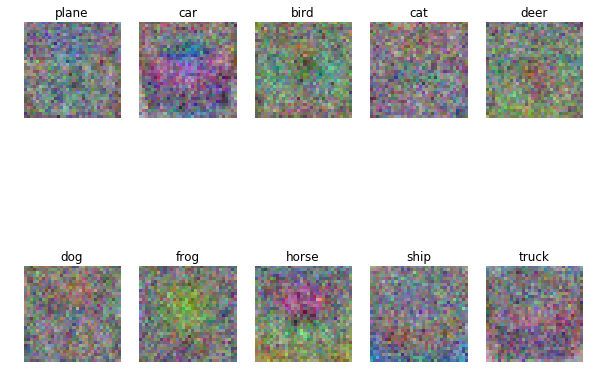

In [64]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])